## Imports


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from oqd_core.interface.atomic import (
    AtomicCircuit,
    Beam,
    Ion,
    Level,
    Phonon,
    Pulse,
    SequentialProtocol,
    System,
    Transition,
)

from oqd_trical.backend import QutipBackend

In [2]:
matplotlib.rcParams["figure.figsize"] = (12, 8)
matplotlib.rcParams["font.size"] = 20
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

## Atomic Circuit


In [3]:
downstate = Level(
    principal=6,
    spin=1 / 2,
    orbital=0,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=0,
    spin_orbital_nuclear_magnetization=0,
    energy=2 * np.pi * 0,
    label="q0",
)
estate = Level(
    principal=5,
    spin=1 / 2,
    orbital=1,
    nuclear=1 / 2,
    spin_orbital=1 / 2,
    spin_orbital_nuclear=1,
    spin_orbital_nuclear_magnetization=-1,
    energy=2 * np.pi * 100,
    label="e0",
)

transitions = [
    Transition(
        level1=downstate, level2=estate, einsteinA=1, multipole="E1", label="q0->e0"
    ),
]

Yb171 = Ion(
    mass=171,
    charge=1,
    position=[0, 0, 0],
    levels=[downstate, estate],
    transitions=transitions,
)

COM_x = Phonon(energy=2 * np.pi * 1, eigenvector=[1, 0, 0])

system = System(
    ions=[
        Yb171,
    ],
    modes=[
        COM_x,
    ],
)

beam = Beam(
    transition=transitions[0],
    rabi=2 * np.pi * 0.1,
    detuning=0,
    phase=0,
    polarization=[0, 1, 0],
    wavevector=[1, 0, 0],
    target=0,
)

protocol = SequentialProtocol(sequence=[Pulse(beam=beam, duration=10)])

circuit = AtomicCircuit(system=system, protocol=protocol)

### Serialization & Deserialization


In [4]:
import json

circuit_json = circuit.model_dump_json()
circuit_json = json.dumps(json.loads(circuit_json), indent=2)

with open("9a_example_no_floquet.json", "w") as f:
    f.write(circuit_json)

In [5]:
with open("9a_example_no_floquet.json", "r") as f:
    circuit_json = f.read()

assert AtomicCircuit.model_validate_json(circuit_json) == circuit

## Qutip Intepreter


In [6]:
from oqd_compiler_infrastructure import Chain, Post

from oqd_trical.light_matter.compiler.approximate import (
    RotatingReferenceFrame,
    RotatingWaveApprox,
)
from oqd_trical.light_matter.compiler.canonicalize import canonicalization_pass_factory

frame_specs = {
    "E0": [0, 2 * np.pi * 100],
    "P0": 2 * np.pi * 1,
}

approx_pass = Chain(
    Post(RotatingReferenceFrame(frame_specs=frame_specs)),
    canonicalization_pass_factory(),
    Post(RotatingWaveApprox(cutoff=2 * np.pi * 100)),
)

backend = QutipBackend(approx_pass=approx_pass)

fock_cutoff = 10
experiment, hilbert_space = backend.compile(circuit, fock_cutoff)

In [7]:
from oqd_compiler_infrastructure import Post

from oqd_trical.light_matter.compiler.visualization import CondensedOperatorPrettyPrint

printer = Post(CondensedOperatorPrettyPrint())

print(printer(backend.intermediate))

AtomicEmulatorCircuit
  - frame: Operator(628.3185307179587 * |1><1|_E0 @ I_P0 + 6.283185307179586 * I_E0 @ C_P0 * A_P0)
  - base: Operator(PrunedOperator)
  - sequence: list
    - 0: AtomicEmulatorGate
      - hamiltonian: Operator(0.31415926535897926 * |1><0|_E0 @ D(13.554293365239742 * exp(1j * (6.283185307179586 * t + 1.5707963267948966)))_P0 + 0.31415926535897926 * |0><1|_E0 @ D(13.554293365239742 * exp(1j * (6.283185307179586 * t + -1.5707963267948966)))_P0)
      - duration: float(10.0)


### Results


In [8]:
result = backend.run(
    experiment,
    hilbert_space=hilbert_space,
    timestep=1e-2,
)

10.0%. Run time:   0.24s. Est. time left: 00:00:00:02


20.0%. Run time:   0.46s. Est. time left: 00:00:00:01


30.0%. Run time:   0.68s. Est. time left: 00:00:00:01


40.0%. Run time:   0.90s. Est. time left: 00:00:00:01


50.1%. Run time:   1.12s. Est. time left: 00:00:00:01


60.1%. Run time:   1.34s. Est. time left: 00:00:00:00


70.1%. Run time:   1.56s. Est. time left: 00:00:00:00


80.1%. Run time:   1.78s. Est. time left: 00:00:00:00


90.1%. Run time:   2.00s. Est. time left: 00:00:00:00


100.0%. Run time:   2.23s. Est. time left: 00:00:00:00


Total run time:   2.23s


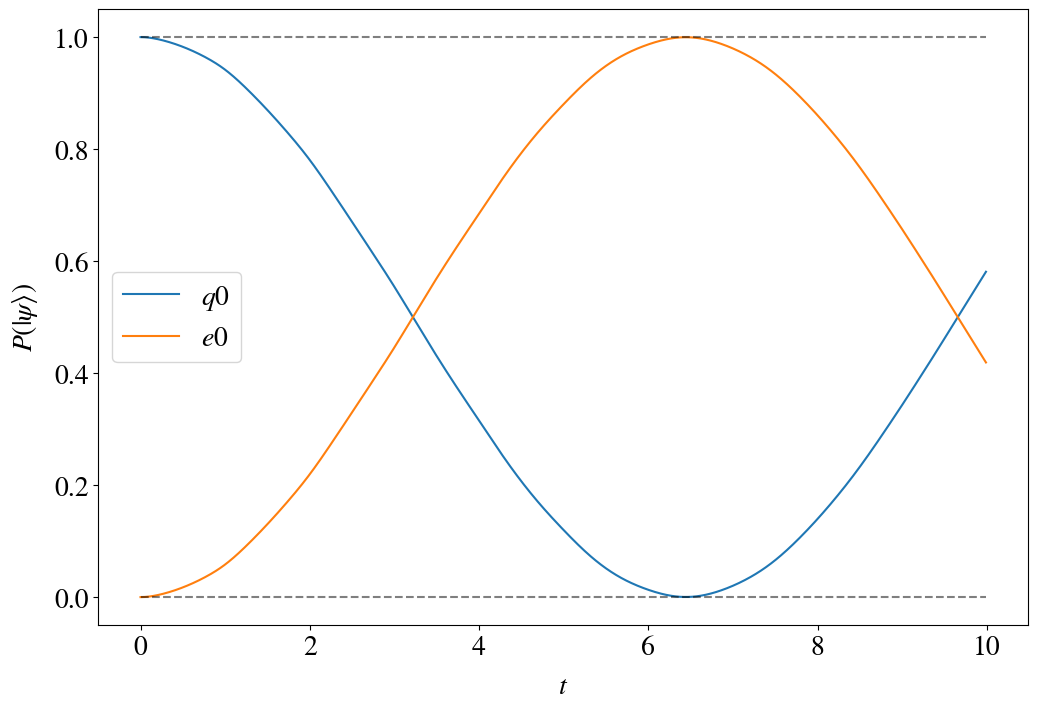

In [9]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(0).diag()[:] for s in result["states"][k]],
    label=[rf"${level.label}$" for level in Yb171.levels],
)
ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.zeros(2),
    "--",
    alpha=0.5,
    color="k",
)
ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.ones(2),
    "--",
    alpha=0.5,
    color="k",
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| \psi \rangle)$", labelpad=10)

ax.legend()

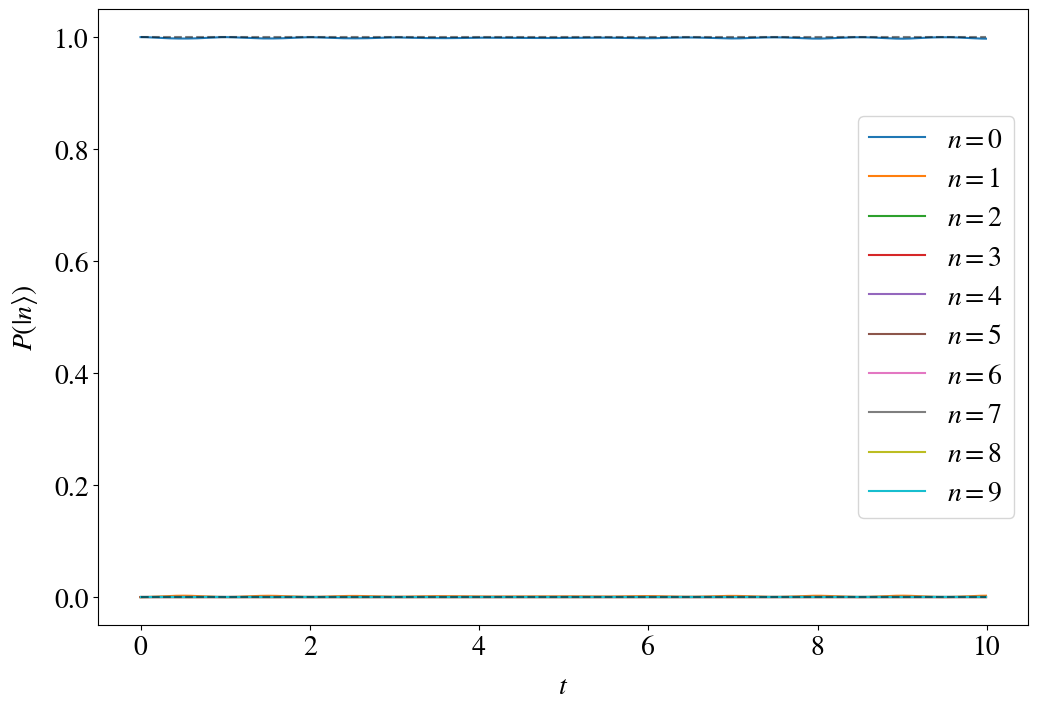

In [10]:
k = slice(None, None, 1)

fig = plt.figure()

ax = fig.subplots(1, 1, sharex=True)

ax.plot(
    result["tspan"][k],
    [s.ptrace(1).diag()[:] for s in result["states"][k]],
    label=[rf"$n={i}$" for i in range(10)],
)

ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.zeros(2),
    "--",
    alpha=0.5,
    color="k",
)
ax.plot(
    result["tspan"][slice(None, None, len(result["tspan"]) - 1)],
    np.ones(2),
    "--",
    alpha=0.5,
    color="k",
)

ax.set_xlabel(r"$t$", labelpad=10)
ax.set_ylabel(r"$P(| n \rangle)$", labelpad=10)

ax.legend()